In [1]:
import os
import sys
from importlib import reload
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
        
from time import time 
import csv
import pickle
import pylab

import numpy as np
import scipy as sc
import pandas as pd
import editdistance

import torch

import rna
import models
import utils
import vae
import designers

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('darkgrid')

2024-04-23 17:01:41.570927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 17:01:41.721381: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-23 17:01:41.721406: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-23 17:01:43.183450: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [4]:
reload(rna)
n_train = 5000
p_mutation = 4 / 50
noise_sd = 0.02
n_hidden = 100
n_epoch = 5
lr = 0.001
n_filters = 32
save_fname_no_ftype = 'nsd{:.2f}-040324'.format(noise_sd, n_hidden)

ridge, ff, cnn, trainseq_n, ytrain_n, testseq_n, ytest_n = rna.train_models(
    n_train,
    p_mutation=p_mutation,
    noise_sd=noise_sd,
    n_hidden=n_hidden,
    n_epoch=n_epoch,
    lr=lr,
    n_filters=n_filters,
    save_fname_no_ftype=save_fname_no_ftype,
)

Generating 5000 labeled sequences...
Done. (56 s)
Generating 5000 labeled sequences...
Done. (56 s)
CV-selected alpha for ridge: 1.0.
No fitness variance estimates provided. Using unweighted MSE loss.
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 113.56it/s]


Epoch 0. Train loss: 0.01. Val loss: 0.16. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 111.91it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 124.05it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 120.39it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 122.34it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 0 sec.
No fitness variance estimates provided. Using unweighted MSE loss.
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 51.46it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.07. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 53.33it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 47.64it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 51.40it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 41.81it/s]

Epoch 4. Train loss: 0.00. Val loss: 0.00. 1 sec.
Saved models to /homefs/home/wongfanc/density-ratio-estimation/rna-models/ff-nsd0.02-040324.pt.
Saved FF model to /homefs/home/wongfanc/density-ratio-estimation/rna-models/ff-nsd0.02-040324.pt.
Saved models to /homefs/home/wongfanc/density-ratio-estimation/rna-models/cnn-nsd0.02-040324.pt.
Saved CNN model to /homefs/home/wongfanc/density-ratio-estimation/rna-models/cnn-nsd0.02-040324.pt.
Saved training data to /homefs/home/wongfanc/density-ratio-estimation/rna-models/traindata-nsd0.02-040324.npz.


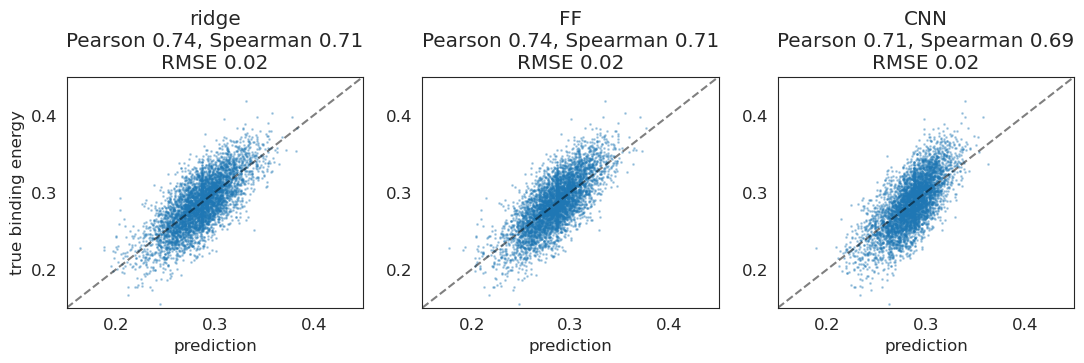

In [5]:
sns.set_style('white')
plt.figure(figsize=(13, 3))
xy_lim = [0.15, 0.45]
model_names = ['ridge', 'FF', 'CNN']

for i, model in enumerate([ridge, ff, cnn]):
    predtest_n = model.predict(testseq_n)
    
    plt.subplot(1, 3, i + 1)
    plt.scatter(predtest_n, ytest_n, alpha=0.3, s=1);
    plt.plot(xy_lim, xy_lim, '--k', alpha=0.5)
    
    r, p = sc.stats.pearsonr(ytest_n, predtest_n)
    rho, p = sc.stats.spearmanr(ytest_n, predtest_n)
    rmse = np.sqrt(np.mean(np.square(ytest_n - predtest_n)))
    
    plt.ylim(xy_lim);
    plt.xlim(xy_lim)
    plt.title('{}\nPearson {:.2f}, Spearman {:.2f}\nRMSE {:.2f}'.format(model_names[i], r, rho, rmse));
    plt.xlabel('prediction');
    if i == 0: 
        plt.ylabel('true binding energy'); 

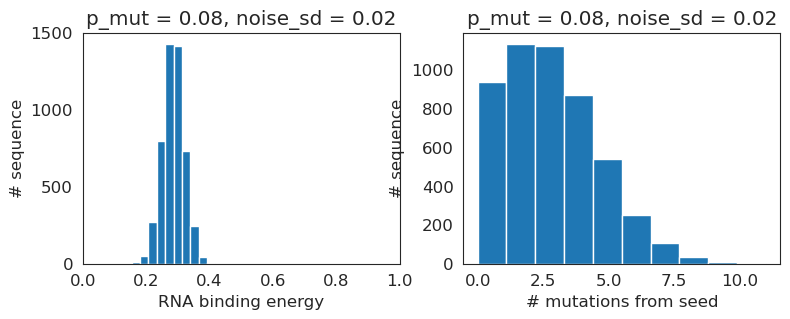

In [6]:
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.hist(ytest_n)
plt.xlabel('RNA binding energy');
plt.ylabel('# sequence');
plt.title('p_mut = {}, noise_sd = {}'.format(p_mutation, noise_sd));
plt.xlim([0, 1]);

plt.subplot(122)
testdist_n = [editdistance.eval(seq, rna.RNABinding.SEEDS[3]) for seq in testseq_n]
plt.hist(testdist_n)
plt.xlabel('# mutations from seed');
plt.ylabel('# sequence');
plt.title('p_mut = {}, noise_sd = {}'.format(p_mutation, noise_sd));

In [ ]:
reload(models)
reload(rna)

PATH = '/homefs/home/wongfanc/density-ratio-estimation/'
n_design = 50000
adalead_thresholds = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01]
biswas_temperatures = [0.05, 0.03, 0.01, 0.005]
model_and_data_fname_no_ftype = 'nsd0.02-040324'
design_pkl_fname = PATH + 'rna-results/designs-nsd0.02-040324.pkl'

name2designs = rna.sample_design_sequences(
    n_design,
    adalead_thresholds,
    biswas_temperatures,
    model_and_data_fname_no_ftype=model_and_data_fname_no_ftype,
    design_pkl_fname=design_pkl_fname
)

Loaded 5000 training points from /homefs/home/wongfanc/density-ratio-estimation/rna-models/traindata-nsd0.02-040324.npz.

Using landscape with binding target 0, seed sequence 3, and noise SD 0.02.
Saving all results to /homefs/home/wongfanc/density-ratio-estimation/rna-results/designs-nsd0.02-040324.pkl.

Designing AdaLead threshold = 0.5 ridge sequences...
  Done. (74 s)
  Mean label, prediction: 0.345, 0.381
  Saved 50000 AdaLead threshold = 0.5 ridge sequences.

Designing AdaLead threshold = 0.4 ridge sequences...
  Done. (74 s)
  Mean label, prediction: 0.346, 0.381
  Saved 50000 AdaLead threshold = 0.4 ridge sequences.

Designing AdaLead threshold = 0.3 ridge sequences...
  Done. (72 s)
  Mean label, prediction: 0.355, 0.388
  Saved 50000 AdaLead threshold = 0.3 ridge sequences.

Designing AdaLead threshold = 0.2 ridge sequences...
  Done. (73 s)
  Mean label, prediction: 0.366, 0.399
  Saved 50000 AdaLead threshold = 0.2 ridge sequences.

Designing AdaLead threshold = 0.1 ridge s

In [7]:
name2designs.keys()

dict_keys(['adalead0.5-ridge', 'adalead0.4-ridge', 'adalead0.3-ridge', 'adalead0.2-ridge', 'adalead0.1-ridge', 'adalead0.05-ridge', 'adalead0.01-ridge', 'biswas1-ridge', 'biswas0.5-ridge', 'biswas0.1-ridge', 'biswas0.05-ridge', 'biswas0.01-ridge', 'cbas-ridge', 'dbas-ridge', 'pex-ridge', 'adalead0.5-ff', 'adalead0.4-ff', 'adalead0.3-ff', 'adalead0.2-ff', 'adalead0.1-ff', 'adalead0.05-ff', 'adalead0.01-ff', 'biswas1-ff', 'biswas0.5-ff', 'biswas0.1-ff', 'biswas0.05-ff', 'biswas0.01-ff', 'cbas-ff', 'dbas-ff', 'pex-ff', 'adalead0.5-cnn', 'adalead0.4-cnn', 'adalead0.3-cnn', 'adalead0.2-cnn', 'adalead0.1-cnn', 'adalead0.05-cnn', 'adalead0.01-cnn', 'biswas1-cnn', 'biswas0.5-cnn', 'biswas0.1-cnn', 'biswas0.05-cnn', 'biswas0.01-cnn', 'cbas-cnn', 'dbas-cnn', 'pex-cnn'])

In [420]:
with open(design_pkl_fname, 'rb') as f:
    loaded_name2designs = pickle.load(f)

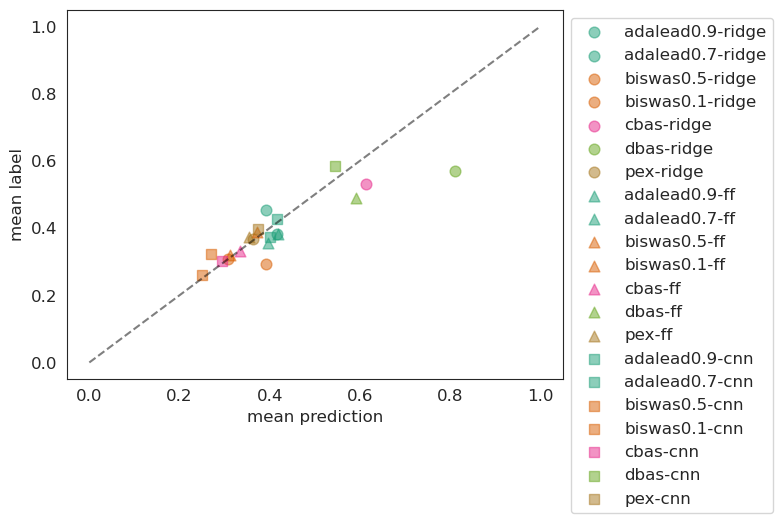

In [435]:
cm = pylab.get_cmap('Dark2')
def name2color(name):
    if 'adalead' in name:
        return cm(0)
    if 'biswas' in name:
        return cm(1 / 5)
    if 'cbas' in name:
        return cm(2 / 5)
    if 'dbas' in name:
        return cm(3 / 5)
    if 'pex' in name:
        return cm(4 / 5)
def name2marker(name):
    if 'ridge' in name:
        return 'o'
    if 'ff' in name:
        return '^'
    if 'cnn' in name:
        return 's'
    
for i, (name, designs) in enumerate(loaded_name2designs.items()):
    seq_n, y_n, pred_n = designs
    plt.scatter(pred_n, y_n, label=name, s=60, alpha=0.5, color=name2color(name), marker=name2marker(name))
    
plt.plot([0, 1], [0, 1], '--k', alpha=0.5)
plt.xlabel('mean prediction');
plt.ylabel('mean label');
plt.legend(bbox_to_anchor=(1, 1), fontsize=10);

# VAE

In [188]:
# generate training data
reload(rna)
n_train = 10000
p_mut = 0.1
noise_sd = 0.02

rnabind = rna.RNABinding()
trainseq_n, ytrain_n = rnabind.get_training_data(
    n_train,
    p_mut,
    noise_sd=noise_sd
)
predtrain_n = model.predict(trainseq_n)

Generating 10000 labeled sequences...
Done. (110 s)


One-hot encoded sequences to shape = (10000, 50, 4) (0 sec)
9000 training data points, 1000 validation data points.
Epoch 0. Train loss: 38.8046, KL: 1.4174, CE: 37.3871. Val loss: 50.5612, KL: 0.0927, CE: 50.4685. (4 s)
Epoch 1. Train loss: 27.2079, KL: 0.1930, CE: 27.0149. Val loss: 21.9387, KL: 0.2615, CE: 21.6772. (4 s)
Epoch 2. Train loss: 26.4693, KL: 0.0467, CE: 26.4227. Val loss: 20.9355, KL: 0.0414, CE: 20.8941. (4 s)
Epoch 3. Train loss: 26.2258, KL: 0.0303, CE: 26.1955. Val loss: 21.5191, KL: 0.0210, CE: 21.4980. (4 s)
Epoch 4. Train loss: 26.2559, KL: 0.0288, CE: 26.2271. Val loss: 22.2393, KL: 0.0158, CE: 22.2235. (4 s)
Epoch 5. Train loss: 26.2686, KL: 0.0225, CE: 26.2460. Val loss: 21.5232, KL: 0.0132, CE: 21.5101. (4 s)
Epoch 6. Train loss: 25.9260, KL: 0.0200, CE: 25.9060. Val loss: 21.2425, KL: 0.0140, CE: 21.2284. (4 s)
Epoch 7. Train loss: 25.9936, KL: 0.0116, CE: 25.9821. Val loss: 21.4337, KL: 0.0119, CE: 21.4218. (4 s)
Epoch 8. Train loss: 26.0141, KL: 0.0122, CE

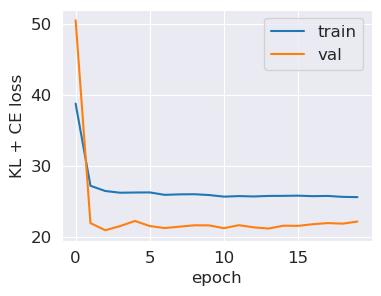

In [212]:
reload(vae)
latent_dim = 10
n_hidden = 20
lr = 0.001
n_epoch = 10

vae_model = vae.VAE(
    latent_dim=latent_dim,
    n_enc_hidden=n_hidden,
    n_dec_hidden=n_hidden
)

loss_df = vae_model.fit(
    trainseq_n,
    weight_n=np.fmax(predtrain_n - 0.35, 0),
    lr=lr,
    n_epoch=n_epoch
)

plt.figure(figsize=(4, 3))
plt.plot(loss_df.index, loss_df['train_loss'], label='train')
plt.plot(loss_df.index, loss_df['val_loss'], label='val')
plt.xlabel('epoch');
plt.ylabel('KL + CE loss');
plt.legend();

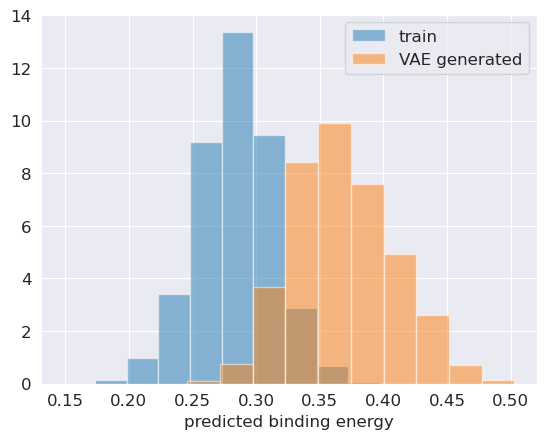

In [213]:
n_sample = 1000

genseq_n = vae_model.generate(n_sample)
ygen_n = rnabind.get_fitness(genseq_n)
predgen_n = model.predict(genseq_n)

plt.figure(figsize=(4, 3))
plt.hist(predtrain_n, alpha=0.5, density=True, label='train')
plt.hist(predgen_n, alpha=0.5, density=True, label='VAE generated')
plt.legend();
plt.xlabel('predicted binding energy');

## DbAS / CbAS

In [26]:
reload(vae)
reload(designers)

latent_dim = 10
n_hidden = 20
weight_type = 'cbas'
device = 'cpu'
model = ridge

cbas = designers.CbAS(
    model,
    trainseq_n,
    latent_dim=latent_dim,
    n_hidden=n_hidden,
    weight_type=weight_type,
    device=device
)

Fitting training distribution:
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.
Epoch 0. Train loss: 21.5400, KL: 0.8487, CE: 20.6913. Val loss: 69.0022, KL: 0.0637, CE: 68.9385. (2 s)
Epoch 1. Train loss: 14.8031, KL: 0.0390, CE: 14.7640. Val loss: 14.9332, KL: 0.0278, CE: 14.9054. (2 s)
Epoch 2. Train loss: 14.6962, KL: 0.0591, CE: 14.6371. Val loss: 14.8307, KL: 0.0368, CE: 14.7939. (2 s)
Epoch 3. Train loss: 14.6439, KL: 0.0601, CE: 14.5838. Val loss: 14.6681, KL: 0.0574, CE: 14.6108. (2 s)
Epoch 4. Train loss: 14.6283, KL: 0.0502, CE: 14.5781. Val loss: 14.6778, KL: 0.0470, CE: 14.6308. (2 s)


In [29]:
n_design = 1000
quantile = 0.9
design_n = cbas.design_sequences(
    n_design,
    quantile=quantile
)

Fitting design distribution with quantile hyperparameter = 0.9:
Iter 0. Mean, SD, max prediction: 0.287, 0.025, 0.362. 1000 valid samples for threshold 0.320. (4 s)
Iter 1. Mean, SD, max prediction: 0.304, 0.026, 0.401. 1000 valid samples for threshold 0.338. (8 s)
Iter 2. Mean, SD, max prediction: 0.318, 0.029, 0.413. 1000 valid samples for threshold 0.356. (13 s)
Iter 3. Mean, SD, max prediction: 0.331, 0.032, 0.464. 999 valid samples for threshold 0.375. (17 s)
Iter 4. Mean, SD, max prediction: 0.346, 0.036, 0.488. 1000 valid samples for threshold 0.397. (22 s)
Iter 5. Mean, SD, max prediction: 0.361, 0.040, 0.529. 1000 valid samples for threshold 0.412. (26 s)
Iter 6. Mean, SD, max prediction: 0.370, 0.039, 0.506. 1000 valid samples for threshold 0.425. (31 s)
Iter 7. Mean, SD, max prediction: 0.369, 0.039, 0.524. 999 valid samples for threshold 0.425. (35 s)
Iter 8. Mean, SD, max prediction: 0.369, 0.040, 0.507. 1000 valid samples for threshold 0.425. (40 s)
Iter 9. Mean, SD, max 

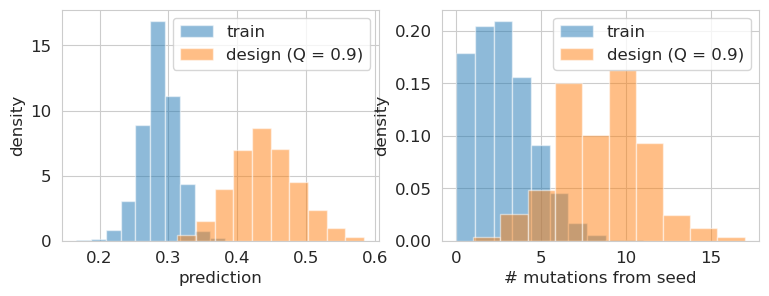

In [30]:
predtrain_n = model.predict(trainseq_n)
preddesign_n = model.predict(design_n)

disttrain_n = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], s) for s in trainseq_n])
distdesign_n = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], s) for s in design_n])

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.hist(predtrain_n, alpha=0.5, label='train', density=True)
plt.hist(preddesign_n, alpha=0.5, label='design (Q = {})'.format(quantile), density=True)
plt.legend()
plt.xlabel('prediction');
plt.ylabel('density');

plt.subplot(122)
plt.hist(disttrain_n, alpha=0.5, label='train', density=True)
plt.hist(distdesign_n, alpha=0.5, label='design (Q = {})'.format(quantile), density=True)
plt.legend()
plt.xlabel('# mutations from seed');
plt.ylabel('density');

# PEX

In [129]:
reload(designers)
pex = designers.PEX(
    model,
    trainseq_n,
    ytrain_n,
    rnabind.SEEDS[3],
)

In [130]:
n_design = 5000
p_mutation = 2 / 50

design_n = pex.design_sequences(
    n_design,
    p_mutation,
)

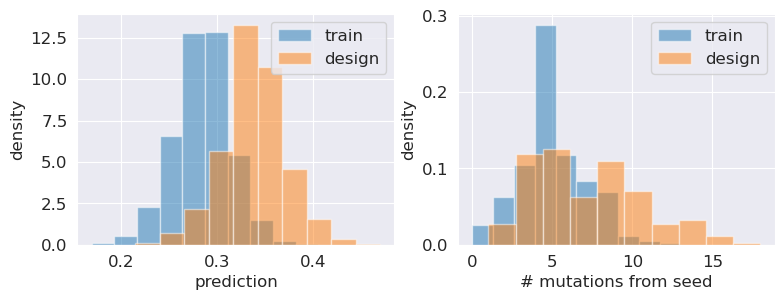

In [131]:
predtrain_n = model.predict(trainseq_n)
preddesign_n = model.predict(design_n)

disttrain_n = np.array([editdistance.eval(rnabind.SEEDS[3], s) for s in trainseq_n])
distdesign_n = np.array([editdistance.eval(rnabind.SEEDS[3], s) for s in design_n])

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.hist(predtrain_n, alpha=0.5, label='train', density=True)
plt.hist(preddesign_n, alpha=0.5, label='design'.format(quantile), density=True)
plt.legend()
plt.xlabel('prediction');
plt.ylabel('density');

plt.subplot(122)
plt.hist(disttrain_n, alpha=0.5, label='train', density=True)
plt.hist(distdesign_n, alpha=0.5, label='design'.format(quantile), density=True)
plt.legend()
plt.xlabel('# mutations from seed');
plt.ylabel('density');

# AdaLead

In [2]:
# debugging (next few cells are messy until one with comment "testing out single setting")
reload(utils)
reload(models)
reload(rna)

n_train = 5000
binding_target_idx = [0]
seed_idx = 3
p_mutation = 4 / 50
noise_sd = 0.02
weight_power = None
n_hidden = 100
n_epoch = 5
lr = 0.001
n_filters = 32
save_fname_no_ftype = None  # 'nsd{:.2f}-h{}-032223'.format(noise_sd, n_hidden)

ridge, ff, cnn, trainseq_n, ytrain_n, testseq_n, ytest_n = rna.train_models(
    n_train,
    binding_target_idx=binding_target_idx,
    seed_idx=seed_idx,
    weight_power=weight_power,
    p_mutation=p_mutation,
    noise_sd=noise_sd,
    n_hidden=n_hidden,
    n_epoch=n_epoch,
    lr=lr,
    n_filters=n_filters,
    save_fname_no_ftype=save_fname_no_ftype,
)

Generating 5000 labeled sequences...
Done. (56 s)
Generating 5000 labeled sequences...
Done. (56 s)
CV-selected alpha for ridge: 1.0.
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 118.79it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.06. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 114.45it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 116.37it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 104.01it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 114.48it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 0 sec.
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 54.60it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.04. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 49.29it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 53.45it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 53.65it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 53.25it/s]

Epoch 4. Train loss: 0.00. Val loss: 0.00. 1 sec.
`save_fname_no_ftype` not provided, not saving models or data.


In [502]:
save_path = '/homefs/home/wongfanc/density-ratio-estimation/rna-models'
save_fname_no_ftype = 'target{}-nsd{:.2f}-pmut{:.2f}-032924_v2'.format(binding_target_idx[0], noise_sd, p_mutation)

ff_fname = os.path.join(save_path, 'ff-' + save_fname_no_ftype + '.pt')
ff.save(ff_fname)
print(f'Saved FF model to {ff_fname}.')

cnn_fname = os.path.join(save_path, 'cnn-' + save_fname_no_ftype + '.pt')
cnn.save(cnn_fname)
print(f'Saved CNN model to {cnn_fname}.')

data_fname = os.path.join(save_path, 'traindata-' + save_fname_no_ftype + '.npz')
np.savez(data_fname, trainseq_n=trainseq_n, ytrain_n=ytrain_n)
print(f'Saved training data to {data_fname}.')

Saved models to /homefs/home/wongfanc/density-ratio-estimation/rna-models/ff-target3-nsd0.03-pmut0.08-032924_v2.pt.
Saved FF model to /homefs/home/wongfanc/density-ratio-estimation/rna-models/ff-target3-nsd0.03-pmut0.08-032924_v2.pt.
Saved models to /homefs/home/wongfanc/density-ratio-estimation/rna-models/cnn-target3-nsd0.03-pmut0.08-032924_v2.pt.
Saved CNN model to /homefs/home/wongfanc/density-ratio-estimation/rna-models/cnn-target3-nsd0.03-pmut0.08-032924_v2.pt.
Saved training data to /homefs/home/wongfanc/density-ratio-estimation/rna-models/traindata-target3-nsd0.03-pmut0.08-032924_v2.npz.


In [4]:
# load saved models
noise_sd = 0.03
p_mutation = 4 / 50
n_hidden = 100
n_filters = 32
model_and_data_path = '/homefs/home/wongfanc/density-ratio-estimation/rna-models'
design_pkl_fname = 'target3-nsd{:.2f}-pmut{:.2f}-032924'.format(noise_sd, p_mutation)
model_and_data_fname_no_ftype = 'target3-nsd0.03-pmut0.08-032924'

data_fname = os.path.join(model_and_data_path, 'traindata-' + model_and_data_fname_no_ftype + '.npz')
d = np.load(data_fname)
trainseq_n = list(d['trainseq_n'])
ytrain_n = d['ytrain_n']
print(f'Loaded {ytrain_n.size} training points from {data_fname}.\n')

# train ridge regression, load trained FF and CNN models
ridge = models.RidgeRegressor(seq_len=50, alphabet=rna.RNA_NUCLEOTIDES)
ridge.fit(trainseq_n, ytrain_n)

ff_fname = os.path.join(model_and_data_path, 'ff-' + model_and_data_fname_no_ftype + '.pt')
ff = models.FeedForward(50, rna.RNA_NUCLEOTIDES, n_hidden)
ff.load(ff_fname)

cnn_fname = os.path.join(model_and_data_path, 'cnn-' + model_and_data_fname_no_ftype + '.pt')
cnn = models.CNN(50, rna.RNA_NUCLEOTIDES, n_filters, n_hidden)
cnn.load(cnn_fname)

Loaded 5000 training points from /homefs/home/wongfanc/density-ratio-estimation/rna-models/traindata-target3-nsd0.03-pmut0.08-032924.npz.



In [3]:
# load calibration data
PATH = '/homefs/home/wongfanc/density-ratio-estimation/'
fname = os.path.join(PATH, 'rna-results', 'calibration-pm{:.2f}-nsd{:.2f}-040124.npz'.format(p_mutation, noise_sd))
d = np.load(fname)
testseq_n = list(d['calseqs_n'])
ytest_n = d['ycal_n']

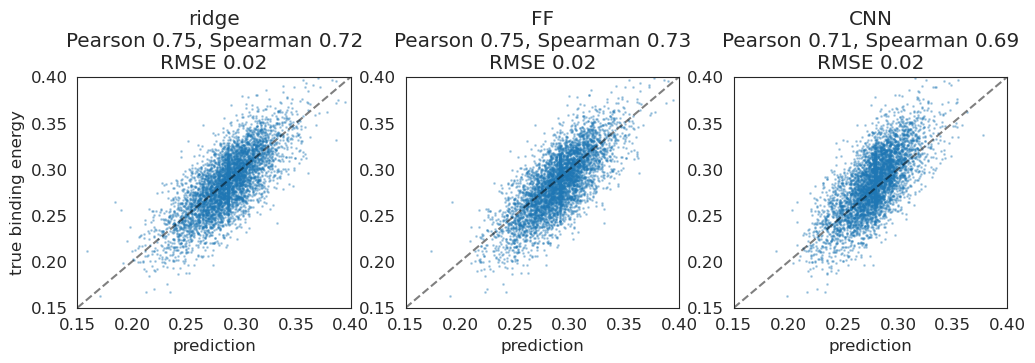

In [3]:
sns.set_style('white')
plt.figure(figsize=(12, 3))
xy_lim = [0.15, 0.4]
model_names = ['ridge', 'FF', 'CNN']

for i, model in enumerate([ridge, ff, cnn]):
    predtest_n = model.predict(testseq_n)
    
    plt.subplot(1, 3, i + 1)
    plt.scatter(predtest_n, ytest_n, alpha=0.3, s=1);
    plt.plot(xy_lim, xy_lim, '--k', alpha=0.5)
    
    r, p = sc.stats.pearsonr(ytest_n, predtest_n)
    rho, p = sc.stats.spearmanr(ytest_n, predtest_n)
    rmse = np.sqrt(np.mean(np.square(ytest_n - predtest_n)))
    
    plt.ylim(xy_lim);
    plt.xlim(xy_lim)
    plt.title('{}\nPearson {:.2f}, Spearman {:.2f}\nRMSE {:.2f}'.format(model_names[i], r, rho, rmse));
    plt.xlabel('prediction');
    if i == 0: 
        plt.ylabel('true binding energy'); 

In [15]:
reload(designers)

binding_target_idx = [0]
noise_sd = 0.02
n_recomb_partner = 0
recomb_rate = 0
n_design = 10000
max_model_queries = 5 * n_design
thresholds = [0.3, 0.2, 0.1, 0.05, 0.01]
model = ridge

landscape = rna.RNABinding(binding_target_idx=binding_target_idx)

adalead = designers.AdaLead(
    model,
    trainseq_n,
    ytrain_n
)

thresh2results = {}
for thresh in thresholds:
    
    t0 = time()
    design_n = adalead.design_sequences(
        n_design=n_design,
        max_model_queries=max_model_queries,
        threshold=thresh,
        n_recomb_partner=n_recomb_partner,
        recomb_rate=recomb_rate,
    )
    print(int(time() - t0))
    
    preddesign_n = model.predict(design_n)
    ydesign_n = landscape.get_fitness(design_n)
    ydesign_n = sc.stats.norm.rvs(loc=ydesign_n, scale=noise_sd)
    print(thresh, np.mean(preddesign_n), np.mean(ydesign_n))
    thresh2results[thresh] = (ydesign_n, preddesign_n)


13
0.3 0.39121440576596156 0.3484538777311231
13
0.2 0.40427906766531085 0.3617071605111294
11
0.1 0.41340743923862927 0.3723127199848805
16
0.05 0.42708684851231654 0.3809750479705359
23
0.01 0.4352145842705473 0.3736797619733132


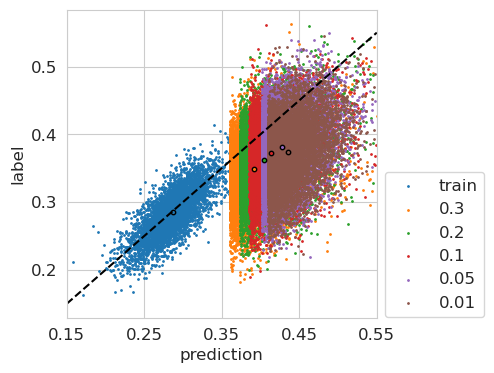

In [16]:
sns.set_style('whitegrid')
plt.figure(figsize=(4, 4))
cm = pylab.get_cmap('tab10')
xy_lim = [0.15, 0.55]

predtest_n = model.predict(testseq_n)
plt.scatter(predtest_n, ytest_n, label='train', alpha=1, s=1)

for i, thresh in enumerate(thresholds):
    color = cm(i + 1)
    ydesign_n, preddesign_n = thresh2results[thresh]
    plt.scatter(preddesign_n, ydesign_n, label=thresh, alpha=1, s=1, color=color)

plt.scatter(np.mean(predtest_n), np.mean(ytest_n), edgecolor='k', s=10, color=cm(0))
for i, thresh in enumerate(thresholds):
    color = cm(i + 1)
    ydesign_n, preddesign_n = thresh2results[thresh]
    plt.scatter(np.mean(preddesign_n), np.mean(ydesign_n), edgecolor='k', s=10, color=color)

plt.plot(xy_lim, xy_lim, '--k')
plt.xlim(xy_lim)
plt.xlim(xy_lim)
plt.legend(bbox_to_anchor=(1, 0.5));
plt.xticks(np.arange(xy_lim[0], xy_lim[1] + 0.01, 0.1));
plt.xlabel('prediction');
plt.ylabel('label');

In [15]:
# seeing how different weight_powers affect performance on top quantiles of test labels
weight_power = 3

quantiles = np.arange(0.8, 1, 0.02)
metrics_mxqx3 = np.zeros([3, quantiles.size, 3])

for i, q in enumerate(quantiles):
    
    threshold = np.quantile(ytrain_n, q)
    train_idx = np.where(ytrain_n < threshold)[0]
    test_idx = np.where(ytrain_n >= threshold)[0]
    print(threshold,train_idx.size, test_idx.size)
    
    ytr_n = ytrain_n[train_idx]
    yte_n = ytrain_n[test_idx]
    trseq_n = [trainseq_n[k] for k in train_idx]
    teseq_n = [trainseq_n[k] for k in test_idx]
    
    weight_n = np.fmax(np.power(ytr_n - np.min(ytr_n), weight_power), 1e-6)
    weight_n = weight_n * weight_n.size / np.sum(weight_n)
    
    ridge.fit(trseq_n, ytr_n, weight_n=weight_n)
    predtest_n = ridge.predict(teseq_n)
    
    r, p = sc.stats.pearsonr(yte_n, predtest_n)
    rho, p = sc.stats.spearmanr(yte_n, predtest_n)
    rmse = np.sqrt(np.mean(np.square(yte_n - predtest_n)))

    metrics_mxqx3[0, i] = r, rho, rmse
    
    yvar_nx2 = np.hstack([ytr_n[:, None], 1. / weight_n[:, None]])

    ff = models.FeedForward(landscape.SEQ_LEN, rna.RNA_NUCLEOTIDES, n_hidden)
    _ = ff.fit(
        trseq_n,
        yvar_nx2,
        n_epoch=n_epoch,
        lr=lr,
    )
    predtest_n = ff.predict(teseq_n)
    
    r, p = sc.stats.pearsonr(yte_n, predtest_n)
    rho, p = sc.stats.spearmanr(yte_n, predtest_n)
    rmse = np.sqrt(np.mean(np.square(yte_n - predtest_n)))

    metrics_mxqx3[1, i] = r, rho, rmse
    
    cnn = models.CNN(landscape.SEQ_LEN, rna.RNA_NUCLEOTIDES, n_filters, n_hidden)
    _ = cnn.fit(
        trseq_n,
        yvar_nx2,
        n_epoch=n_epoch,
        lr=lr,
    )
    predtest_n = cnn.predict(teseq_n)
    
    r, p = sc.stats.pearsonr(yte_n, predtest_n)
    rho, p = sc.stats.spearmanr(yte_n, predtest_n)
    rmse = np.sqrt(np.mean(np.square(yte_n - predtest_n)))
    
    metrics_mxqx3[2, i] = r, rho, rmse
    
    print('done with {}'.format(q))
    print()
    
    

0.3306609596897084 4000 1000
One-hot encoded sequences to shape = (4000, 50, 4) (0 sec)
3600 training data points, 400 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 96.04it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.02. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 104.10it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 90.94it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 94.95it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 94.94it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 0 sec.
One-hot encoded sequences to shape = (4000, 50, 4) (0 sec)
3600 training data points, 400 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 47.65it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.05. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 49.14it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 45.67it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 49.62it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 45.07it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 1 sec.
done with 0.8

0.33390097809978925 4100 900
One-hot encoded sequences to shape = (4100, 50, 4) (0 sec)
3690 training data points, 410 validation data points.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 107.28it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.06. 0 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 97.72it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 108.73it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 98.51it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 97.07it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 0 sec.
One-hot encoded sequences to shape = (4100, 50, 4) (0 sec)
3690 training data points, 410 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 49.19it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.07. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 43.51it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 42.43it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 48.18it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 47.06it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 1 sec.
done with 0.8200000000000001

0.3369702404283807 4200 800
One-hot encoded sequences to shape = (4200, 50, 4) (0 sec)
3780 training data points, 420 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 99.28it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.07. 0 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 92.43it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 114.79it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 96.87it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 102.78it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 0 sec.
One-hot encoded sequences to shape = (4200, 50, 4) (0 sec)
3780 training data points, 420 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 50.18it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.04. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 46.42it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 47.50it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 47.85it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 50.64it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 1 sec.
done with 0.8400000000000001

0.34047821553898866 4300 700
One-hot encoded sequences to shape = (4300, 50, 4) (0 sec)
3870 training data points, 430 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 99.21it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.06. 0 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 98.57it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 115.55it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 103.17it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 101.47it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 0 sec.
One-hot encoded sequences to shape = (4300, 50, 4) (0 sec)
3870 training data points, 430 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 49.65it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.04. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 43.19it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 46.21it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 49.05it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 47.58it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 1 sec.
done with 0.8600000000000001

0.3443021962392005 4400 600
One-hot encoded sequences to shape = (4400, 50, 4) (0 sec)
3960 training data points, 440 validation data points.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 110.61it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.04. 0 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 98.91it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 105.50it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 106.21it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 99.14it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 0 sec.
One-hot encoded sequences to shape = (4400, 50, 4) (0 sec)
3960 training data points, 440 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 47.57it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.05. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 48.96it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 49.60it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 52.21it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 47.02it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 1 sec.
done with 0.8800000000000001

0.34937177571415595 4500 500
One-hot encoded sequences to shape = (4500, 50, 4) (0 sec)
4050 training data points, 450 validation data points.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 100.58it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.05. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 102.68it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 112.09it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 98.19it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 121.70it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 0 sec.
One-hot encoded sequences to shape = (4500, 50, 4) (0 sec)
4050 training data points, 450 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 47.62it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.07. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 51.82it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 49.28it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 52.24it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 49.82it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 1 sec.
done with 0.9000000000000001

0.35591568935878587 4600 400
One-hot encoded sequences to shape = (4600, 50, 4) (0 sec)
4140 training data points, 460 validation data points.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 109.79it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.03. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 107.37it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 104.81it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 117.08it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 110.11it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 0 sec.
One-hot encoded sequences to shape = (4600, 50, 4) (0 sec)
4140 training data points, 460 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 46.46it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.05. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 48.39it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 51.65it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 50.63it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 49.03it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 1 sec.
done with 0.9200000000000002

0.36299503079769396 4700 300
One-hot encoded sequences to shape = (4700, 50, 4) (0 sec)
4230 training data points, 470 validation data points.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 123.01it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.05. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 112.68it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 120.85it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 107.53it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 107.22it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 0 sec.
One-hot encoded sequences to shape = (4700, 50, 4) (0 sec)
4230 training data points, 470 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 47.50it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.06. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 49.53it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 45.53it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 50.16it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 51.61it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 1 sec.
done with 0.9400000000000002

0.3702592996730147 4800 200
One-hot encoded sequences to shape = (4800, 50, 4) (0 sec)
4320 training data points, 480 validation data points.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 101.44it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.06. 0 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 94.97it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 106.35it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 110.52it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 112.97it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 0 sec.
One-hot encoded sequences to shape = (4800, 50, 4) (0 sec)
4320 training data points, 480 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 50.09it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.05. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 50.85it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 49.24it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 49.35it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 53.11it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 1 sec.
done with 0.9600000000000002

0.3845925475886619 4900 100
One-hot encoded sequences to shape = (4900, 50, 4) (0 sec)
4410 training data points, 490 validation data points.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 116.02it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.06. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 125.13it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 104.64it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 104.13it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 104.18it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 0 sec.
One-hot encoded sequences to shape = (4900, 50, 4) (0 sec)
4410 training data points, 490 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 51.19it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.05. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 50.95it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 49.67it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 51.29it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 50.00it/s]

Epoch 4. Train loss: 0.00. Val loss: 0.00. 1 sec.
done with 0.9800000000000002



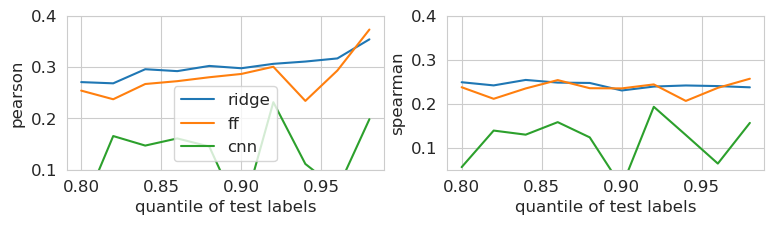

In [16]:
sns.set_style('whitegrid')
model_names = ['ridge', 'ff', 'cnn']
metric_names = ['pearson', 'spearman']
ylims = [[0.1, 0.4], [0.05, 0.4] ]
plt.figure(figsize=(9, 2))
for j in range(2):
    plt.subplot(1, 2, j + 1)
    for i in range(3):
        plt.plot(quantiles, metrics_mxqx3[i, :, j], label=model_names[i])
    plt.ylabel(metric_names[j])
    plt.xlabel('quantile of test labels');
    plt.ylim(ylims[j])
    if j == 0:
        plt.legend();

In [298]:
# testing out single setting
reload(designers)

n_recomb_partner = 1
recomb_rate = 0.2
n_design = 5000
threshold = 0.05
print_every = 2000

adalead = designers.AdaLead(
    model,
    trainseq_n,
    ytrain_n
)
design_n = adalead.design_sequences(
    n_design=n_design,
    threshold=threshold,
    n_recomb_partner=n_recomb_partner,
    recomb_rate=recomb_rate,
    print_every=print_every
)

Designed 2000 / 10000 candidates (2 s).
Designed 4000 / 10000 candidates (6 s).
Designed 6000 / 10000 candidates (9 s).
Designed 8000 / 10000 candidates (12 s).
Designed 10000 / 10000 candidates (15 s).
5000


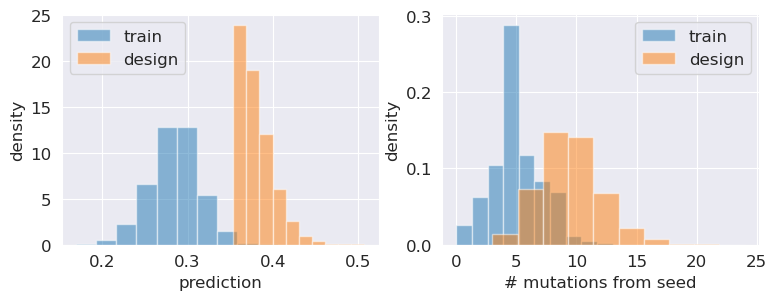

In [299]:
predtrain_n = model.predict(trainseq_n)
preddesign_n = model.predict(design_n)

disttrain_n = np.array([editdistance.eval(rnabind.SEEDS[3], s) for s in trainseq_n])
distdesign_n = np.array([editdistance.eval(rnabind.SEEDS[3], s) for s in design_n])

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.hist(predtrain_n, alpha=0.5, label='train', density=True)
plt.hist(preddesign_n, alpha=0.5, label='design'.format(quantile), density=True)
plt.legend()
plt.xlabel('prediction');
plt.ylabel('density');

plt.subplot(122)
plt.hist(disttrain_n, alpha=0.5, label='train', density=True)
plt.hist(distdesign_n, alpha=0.5, label='design'.format(quantile), density=True)
plt.legend()
plt.xlabel('# mutations from seed');
plt.ylabel('density');

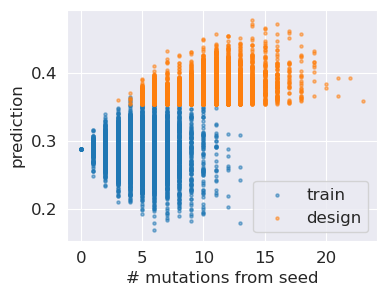

In [207]:
predtrain_n = model.predict(trainseq_n)
preddesign_n = model.predict(design_n)

disttrain_n = np.array([editdistance.eval(rnabind.SEEDS[3], s) for s in trainseq_n])
distdesign_n = np.array([editdistance.eval(rnabind.SEEDS[3], s) for s in design_n])

plt.figure(figsize=(4, 3))
plt.scatter(disttrain_n, predtrain_n, alpha=0.5, label='train', s=5)
plt.scatter(distdesign_n, preddesign_n, alpha=0.5, label='design', s=5)
plt.legend()
plt.xlabel('# mutations from seed');
plt.ylabel('prediction');


# Biswas

In [22]:
# find good trust radius
disttrain_n = np.array([editdistance.eval(landscape.SEEDS[3], s) for s in trainseq_n])
for q in np.arange(0.5, 1.0, 0.05):
    print(round(4, 2), np.quantile(disttrain_n, q))

0.5 4.0
0.55 4.0
0.6000000000000001 4.0
0.6500000000000001 5.0
0.7000000000000002 5.0
0.7500000000000002 5.0
0.8000000000000003 6.0
0.8500000000000003 6.0
0.9000000000000004 6.0
0.9500000000000004 7.0


In [45]:
reload(designers)

n_design = 100
seed_seq = rna.RNABinding.SEEDS[3]
max_mu = 2
temperature = 0.005
n_trust_radius_mutations = 5
n_step = 500
print_every = 100
model = ridge

biswas = designers.Biswas(model, trainseq_n)
design_n, pred_nxt1, acceptprob_nxt = biswas.design_sequences(
    n_design,
    seed_seq,
    max_mu,
    temperature,
    n_trust_radius_mutations,
    n_step,
    print_every
)

Initialization. Mean, SD prediction: 0.293, 0.021.
Step 100. Mean, SD acceptance probability: 0.077, 0.245. Mean, SD prediction: 0.344, 0.028. (0 s)
Step 200. Mean, SD acceptance probability: 0.018, 0.110. Mean, SD prediction: 0.358, 0.027. (1 s)
Step 300. Mean, SD acceptance probability: 0.030, 0.155. Mean, SD prediction: 0.368, 0.025. (1 s)
Step 400. Mean, SD acceptance probability: 0.014, 0.102. Mean, SD prediction: 0.376, 0.026. (2 s)
Step 500. Mean, SD acceptance probability: 0.018, 0.107. Mean, SD prediction: 0.383, 0.025. (2 s)


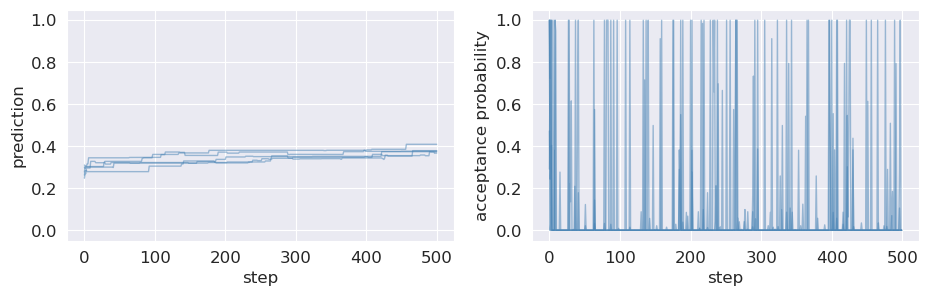

In [46]:
n_to_plot = 5
plt.figure(figsize=(11, 3))
plt.subplot(121)
plt.plot(pred_nxt1[: n_to_plot].T, linewidth=1, c='steelblue', alpha=0.5);
plt.ylim([-0.05, 1.05])
plt.xlabel('step');
plt.ylabel('prediction');

plt.subplot(122)
plt.plot(acceptprob_nxt[: n_to_plot].T, linewidth=1, c='steelblue', alpha=0.5);
plt.ylim([-0.05, 1.05])
plt.xlabel('step');
plt.ylabel('acceptance probability');

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 99.]),
 array([4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <BarContainer object of 10 artists>)

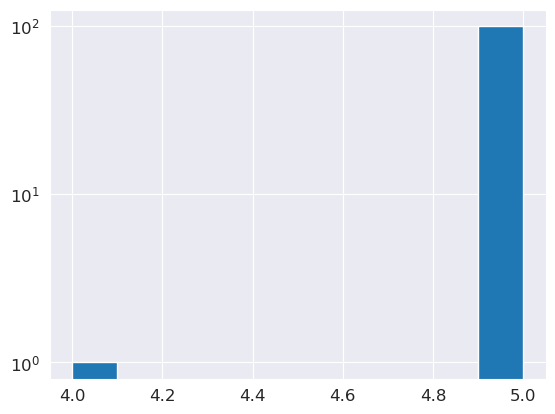

In [40]:
plt.hist(distdesign_n, log=True)

mean prediction 0.39, mean label 0.37


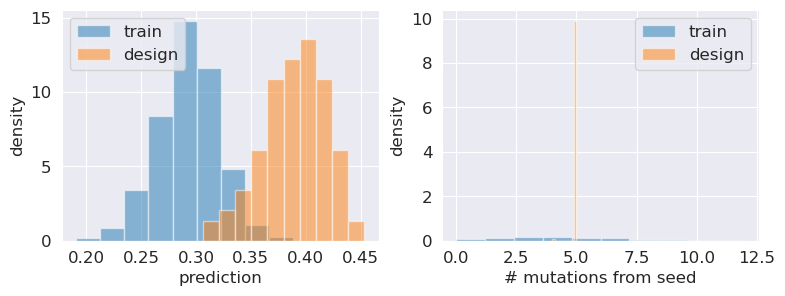

In [13]:
landscape = rna.RNABinding(binding_target_idx=[3])

predtrain_n = model.predict(trainseq_n)
preddesign_n = model.predict(design_n)
ydesign_n = landscape.get_fitness(design_n)
print('mean prediction {:.2f}, mean label {:.2f}'.format(np.mean(preddesign_n), np.mean(ydesign_n)))

disttrain_n = np.array([editdistance.eval(landscape.SEEDS[3], s) for s in trainseq_n])
distdesign_n = np.array([editdistance.eval(landscape.SEEDS[3], s) for s in design_n])

plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.hist(predtrain_n, alpha=0.5, label='train', density=True)
plt.hist(preddesign_n, alpha=0.5, label='design', density=True)
plt.legend()
plt.xlabel('prediction');
plt.ylabel('density');

plt.subplot(122)
plt.hist(disttrain_n, alpha=0.5, label='train', density=True)
plt.hist(distdesign_n, alpha=0.5, label='design', density=True)
plt.legend()
plt.xlabel('# mutations from seed');
plt.ylabel('density');

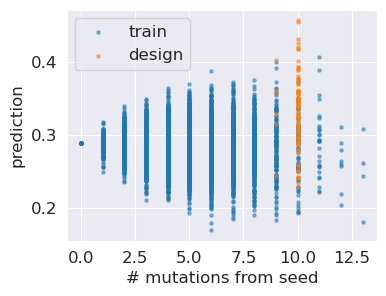

In [376]:
plt.figure(figsize=(4, 3))
plt.scatter(disttrain_n, predtrain_n, alpha=0.5, label='train', s=5)
plt.scatter(distdesign_n, preddesign_n, alpha=0.5, label='design', s=5)
plt.legend()
plt.xlabel('# mutations from seed');
plt.ylabel('prediction');
